# Show and Tell v23

In [1]:
# !pip install torch
# !pip install torch torchvision transformers
# !pip install --upgrade transformers
# !pip install matplotlib
# !pip install nltk
# !pip install tensorflow
# !pip install msgpack
!pip install sklearn

import os
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from collections import Counter
from itertools import chain
from PIL import Image
import random
from transformers import ViTFeatureExtractor, ViTModel
from transformers import SwinForImageClassification
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms.functional import to_pil_image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import gzip
import msgpack
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torchvision.models import swin_t
from torchvision.transforms import ToTensor
from PIL import Image
!pip install sentencepiece
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.cluster import KMeans

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [2]:
# Switch to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
print(torch.version.cuda)


11.8


# Dataset Class

Below we have defined the dataset class, which shall be used throughout the project to access the images, and their respective captions. 

In [4]:
class CustomCocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        with open(annotation_file, 'r') as f:
            self.data = json.load(f)

        # Create a mapping from image IDs to filenames
        self.id_to_filename = {item['id']: item['file_name'] for item in self.data['images']}

        # Create a mapping from image IDs to captions
        # Note that there might be multiple captions per image
        self.id_to_captions = {}
        for annotation in self.data['annotations']:
            image_id = annotation['image_id']
            if image_id not in self.id_to_captions:
                self.id_to_captions[image_id] = []
            self.id_to_captions[image_id].append(annotation['caption'])

        self.transform = transform

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        # Retrieve the image info
        image_info = self.data['images'][idx]
        image_id = image_info['id']
        img_filename = self.id_to_filename[image_id]

        # Load the image
        img_path = os.path.join(self.root_dir, img_filename)
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Retrieve the corresponding captions
        captions = self.id_to_captions[image_id][:1]
        return image, captions

Here we define a function to transform the dimensions and format of all the images to make them consistent in order to properly input them into the SWIN Transformer. 

In [5]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize(256),  # Resize to slightly larger than required size
    transforms.CenterCrop(224),  # Crop to the required size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Data Loader and Dataset Initialization

Hyperparameters. 

The training dataset is about 118k images large, but all of it has not been used due to computational limitations. Batchsize and Epochs can also be increased given additional computational capacity. 

In [6]:
trainSize = 1024
valSize = 32
batchSize = 32
epochs = 5

Initialize the dataset, including the train and validation data, and their respective captions, found in the .json files. Test data has not been used as it does not contain any captions, but the validation dataset shall serve as the test dataset for all intents and purposes. As a result, any validation/development to be done shall be performed on a subset of the train dataset which shall be disjoint from the data trained on. 

IID Sampling has been performed on the dataset in order to ensure that the subset selected does not contain any class imbalances. Further, the "shuffle" parameter has been turned to True within the data loader, thus each time the model is trained, samples are provided in a random order to reduce the chance of overfitting. 

In [7]:
# Initialize the dataset with the feature extractor
coco_dataset = CustomCocoDataset(
    root_dir='train2017',
    annotation_file='captions_train2017.json',
    transform=transform
)

coco_val_dataset = CustomCocoDataset(
    root_dir='val2017',
    annotation_file='captions_val2017.json',
    transform=transform
)

random.seed = 42

# Shuffle the indices
indices = list(range(len(coco_dataset)))
random.shuffle(indices)

# Take a subset of the first 2048 items
subset_indices = indices[:trainSize]
coco_dataset = Subset(coco_dataset, subset_indices)

val_indices = list(range(len(coco_val_dataset)))
random.shuffle(val_indices)
subset_val_indices = val_indices[:valSize]
coco_val_dataset = Subset(coco_val_dataset, subset_val_indices)

# DataLoader
data_loader = DataLoader(dataset=coco_dataset, batch_size=batchSize, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=coco_val_dataset, batch_size=batchSize, shuffle=True, num_workers=0)

# Testing Data Loader

This function shall allow for images within the dataset to be displayed in the notebook. 

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to be between 0 and 1
    plt.axis('off')  # This line hides the axis
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

You can test if the data loader is working by running the below code block. It takes in one batch of images, and displays the first one from the batch. 

Size of the batch (images): torch.Size([32, 3, 224, 224])
Number of captions in this batch: 32


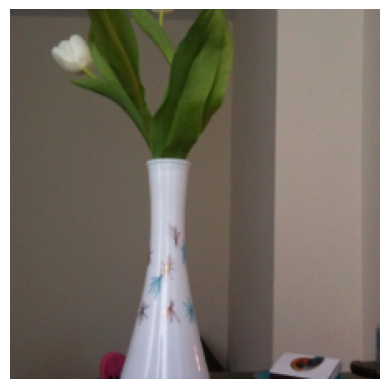

In [9]:
# Fetch one batch of images
for images, captions in data_loader:
    break

# If you want to display the size of this batch or perform any simple operation
print(f"Size of the batch (images): {images.size()}")
print(f"Number of captions in this batch: {len(captions[0])}")
imshow(images[0])

# Preprocess Captions

The 'preprocess_captions' function takes as argument the data loader, and while iterating through all the captions, prepends a start token 'startword' and appends an end token 'endword' to each caption. They are also changed to lowercase, and tokenized using .split(). 

A vocabulary is constructed from the captions, consisting of every word that occurs once or more (basically, all of them!)

In [10]:
nltk.download('punkt')

def preprocess_captions(data_loader):
    captions = []
    for _, caps in data_loader:
        for cap in caps[0]:
            updated_cap = f'startword {cap.lower()} endword'

            # Tokenize the updated caption
            tokens = updated_cap.split()
            captions.append(tokens)


    word_count = Counter()
    # Build a vocabulary
    for cap in captions:
        word_count.update(cap)

    min_word_freq = 1

    vocab = [word for word in word_count if word_count[word] >= min_word_freq]

    # Create a tokenizer and fit it on the updated captions
    tokenizer = Tokenizer(num_words=len(vocab))
    tokenizer.fit_on_texts([" ".join(caption) for caption in captions])
    return tokenizer, word_count, vocab

tokenizer, word_count, vocab = preprocess_captions(data_loader)

[nltk_data] Downloading package punkt to C:\Users\xlab-
[nltk_data]     shared\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The code below is used during inference, helping convert token indices back to words. 

In [11]:
index_to_word = {index: word for word, index in tokenizer.word_index.items()}

# Function to convert a list of indices to words
def indices_to_words(indices):
    return ' '.join([index_to_word.get(index, '') for index in indices])

# Evaluation Script

In [12]:
def evaluate(predictions, true_labels):
    chencherry = SmoothingFunction()

    scores = []
        
    for i in range(len(predictions)):
        truth = [true_labels[i].split()]
        pred = predictions[i].split()
        score = sentence_bleu(truth, pred, smoothing_function=chencherry.method3)

        scores.append(score)
    
    # Tokenize the sentences
    tokenized_pred = [pred.split() for pred in predictions]
    tokenized_true = [[label.split()] for label in true_labels]  # Note the double list for references

    # Calculate corpus-level BLEU score
    score = corpus_bleu(tokenized_true, tokenized_pred)

    print("Maximum BLEU Score (1-1) = ", max(scores))
    print("Average BLEU Score (1-1) = ", sum(scores)/len(scores))
    print("Corpus BLEU score = ", score)

# SWIN Transformer

Here, we have initialized a pre-trained Microsoft SWIN Transformer. This model replaces our previous ResNet50, in the bid for better performance through the use of attention based mechanisms over visual regions. 

In [13]:
model = SwinForImageClassification.from_pretrained('microsoft/swin-base-patch4-window7-224', output_hidden_states=True)
model = model.to(device)
model.eval()

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfO

In [14]:
def extract_features(image):
    """
    Function to extract features from a single image using Swin Transformer.
    :param image: Image tensor with shape (channels, height, width).
    :return: Extracted features.
    """
    image = image.unsqueeze(0)  # Preprocess and add batch dimension
    image = image.to(device)  # Move to the same device as the model

    with torch.no_grad():
        outputs = model(image)
        features = outputs.hidden_states[-1]

    features = features.flatten()
    return features  # Remove batch dimension

In [15]:
feature_mapping = {}
# list_dict = {}

with torch.no_grad():  # Disable gradient computation

    for images, captions in data_loader:

        images = images.to(device)

        for i in range(len(images)):
            features = extract_features(images[i])

            # Move transformed features to CPU and convert to numpy array, if needed
            features.cpu().numpy()

            # Store the transformed features in the dictionary
            feature_mapping[captions[0][i]] = features

In [16]:
feature_mapping_val = {}
# list_dict_val = {}

with torch.no_grad():  # Disable gradient computation
    for images, captions in val_loader:
        images = images.to(device)

        for i in range(len(images)):
            features = extract_features(images[i])

            # Move transformed features to CPU and convert to numpy array, if needed
            features.cpu().numpy()

            # Store the transformed features in the dictionary
            feature_mapping_val[captions[0][i]] = features

# T5 Flan 

In [17]:
# Load Flan T5
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
T5 = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")
T5 = T5.to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:

class ImageCaptioningModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, t5_model_name):
        super(ImageCaptioningModel, self).__init__()
        # Layer to process the image embedding
        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Load pre-trained T5 model and tokenizer
        self.tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
        self.t5 = T5ForConditionalGeneration.from_pretrained(t5_model_name)

        self.t5 = self.t5.to(device)
        
        # Freeze T5 model
        for param in self.t5.parameters():
            param.requires_grad = False
        for param in self.fc.parameters():
            param.requires_grad = True

    def forward(self, embeddings, labels=None):
        # Process image embeddings
        embeddings = self.fc(embeddings)
        embeddings = self.relu(embeddings)
        
        # Flatten the embeddings
        flat_embeddings = embeddings.view(embeddings.size(0), -1)
        
        # Example encoding: Convert embeddings to strings and then tokenize
        # This is a simple placeholder. A more sophisticated encoding scheme can be used.
        encoded_strings = ["Image features: " + " ".join(map(str, e.tolist())) for e in flat_embeddings]
    
        # Tokenize the encoded strings
        tokenized_inputs = self.tokenizer(encoded_strings, padding=True, truncation=True, max_length=512, return_tensors="pt")
    
        # Extract input_ids for T5
        t5_input = tokenized_inputs["input_ids"]
        t5_input = t5_input.to(device)

        # Shift labels to the right by one (prepend with start token) 
        decoder_input_ids = torch.cat([
            torch.full((labels.size(0), 1), self.t5.config.decoder_start_token_id, device=device),
            labels[:, :-1]
        ], dim=-1)

        print(labels.size())

        t5_output = self.t5(input_ids=t5_input, decoder_input_ids=decoder_input_ids, labels=labels if labels is not None else None)

        return t5_output.logits if labels is not None else t5_output.sequences

        # # Initialize decoder_input_ids as the start token for each sequence in the batch
        # decoder_start_token = self.t5.config.decoder_start_token_id
        # batch_size = t5_input.shape[0]
        # decoder_input_ids = torch.full((batch_size, 1), decoder_start_token, device=device)

        # t5_output = self.t5(input_ids=t5_input, decoder_input_ids=decoder_input_ids)
        # return t5_output.logits 

# Parameters
EMBEDDING_DIM = 50176 # Dimension of the Swin Transformer output
HIDDEN_DIM = 512 # A smaller dimension for processed embeddings
T5_MODEL_NAME = "t5-base" # Name of the T5 model

# Create the model
model = ImageCaptioningModel(EMBEDDING_DIM, HIDDEN_DIM, T5_MODEL_NAME)
model = model.to(device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [31]:
loss_function = CrossEntropyLoss()
# Filter parameters that require gradients
trainable_params = [p for p in model.parameters() if p.requires_grad]

# Set up the optimizer with only trainable parameters
optimizer = Adam(trainable_params, lr=0.001)


for epoch in range(epochs):
    total_loss = 0
    for images_batch, captions_batch in data_loader:
        images_batch = images_batch.to(device)
        # Reset the gradients
        optimizer.zero_grad()

        # Initialize batch loss
        batch_loss = 0

        # Process each item in the batch
        for image, caption in zip(images_batch, captions_batch[0]):

            embeddings = feature_mapping.get(caption)
            embeddings = embeddings.to(device)
            # Forward pass for each caption

            labels = model.tokenizer(caption, padding=True, max_length=20, return_tensors="pt").input_ids.to(device)
            label_length = labels.size(1)
            target_length = 20  # The desired length
            
            # Check if padding is needed
            if label_length < target_length:
                # Calculate the number of padding tokens needed
                padding_size = target_length - label_length
            
                # Pad the output tensor
                padding = torch.zeros((1, padding_size), dtype=outputs.dtype).to(device)
                labels_padded = torch.cat([labels, padding], dim=1).to(device)
            else:
                labels_padded = outputs.to(device)

            labels = labels_padded.to(device)
            outputs = model(embeddings.unsqueeze(0), labels)  # Add batch dimension

            print(outputs.size())
            outputs = outputs.float()
            
            batch_size, sequence_length, vocab_size = outputs.shape
            logits_flat = outputs.view(batch_size * sequence_length, vocab_size)
            labels_flat = labels.view(-1)
        
            print(logits_flat.size())
            print(labels_flat.size())
            
            loss = loss_function(logits_flat, labels_flat)

            batch_loss += loss

        # Average the loss across the batch
        batch_loss /= len(captions_batch)

        # Backward pass and optimization
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


torch.Size([1, 20])


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)